In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚀 Training started...


Epoch 500/500: 100%|██████████| 113/113 [00:02<00:00, 46.79it/s]


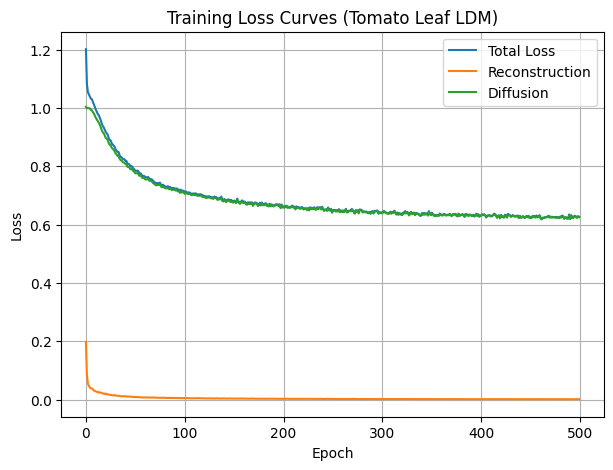

✅ Training complete. Plots & checkpoints saved.


In [ ]:
# ============================================================
# 🍅 TOMATO LEAF LDM TRAINING (256x256)
# 🔥 Latent Diffusion + KL + DDPM Noise
# 📊 Training Visualization for Q1 Journal
# ============================================================

import os, math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# ✅ CONFIG
# -------------------------------
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
EPOCHS = 500
LR = 2e-4
TIMESTEPS = 1000

DATA_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Late_blight"
OUT_DIR   = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LB"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# ✅ DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------
# ✅ DATASET
# -------------------------------
class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith((".jpg", ".png"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

dataset = SingleClassImageDataset(DATA_PATH, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# -------------------------------
# 🧠 MODELS (FIXED FOR 256x256)
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),      # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),# 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),# 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),  # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, d)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 512 * 8 * 8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )
    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))

class LatentUNet(nn.Module):
    def __init__(self, d, t):
        super().__init__()
        self.time_embed = nn.Embedding(t, d)
        self.net = nn.Sequential(
            nn.Linear(d, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, d)
        )
    def forward(self, x, t):
        return self.net(x + self.time_embed(t))

encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet    = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(unet.parameters()), lr=LR
)

# -------------------------------
# 📊 DIFFUSION SCHEDULE
# -------------------------------
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# -------------------------------
# 📈 LOGS
# -------------------------------
total_losses, recon_losses, diff_losses = [], [], []

# -------------------------------
# 🚀 TRAINING
# -------------------------------
print("🚀 Training started...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); unet.train()
    epoch_tot, epoch_rec, epoch_diff = 0, 0, 0

    for imgs,_ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)

        with autocast(device_type=device.type):
            z = encoder(imgs)
            recon = decoder(z)
            rec_loss = F.mse_loss(recon, imgs)

            t = torch.randint(0, TIMESTEPS, (z.size(0),), device=device)
            noise = torch.randn_like(z)
            a = alpha_hat[t][:, None]
            z_noisy = a.sqrt()*z + (1-a).sqrt()*noise

            pred = unet(z_noisy, t)
            diff_loss = F.mse_loss(pred, noise)

            loss = rec_loss + diff_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_tot += loss.item()
        epoch_rec += rec_loss.item()
        epoch_diff += diff_loss.item()

    total_losses.append(epoch_tot/len(loader))
    recon_losses.append(epoch_rec/len(loader))
    diff_losses.append(epoch_diff/len(loader))

    # 🔍 Save samples + checkpoints
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            x,_ = next(iter(loader))
            s = decoder(encoder(x.to(device)))
            save_image((s+1)/2, f"{OUT_DIR}/sample_epoch_{epoch+1}.png", nrow=4)

        torch.save(encoder.state_dict(), f"{OUT_DIR}/encoder_{epoch+1}.pth")
        torch.save(decoder.state_dict(), f"{OUT_DIR}/decoder_{epoch+1}.pth")
        torch.save(unet.state_dict(),    f"{OUT_DIR}/unet_{epoch+1}.pth")

# -------------------------------
# 📊 PLOTS (Q1-READY)
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction")
plt.plot(diff_losses, label="Diffusion")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Curves (Tomato Leaf LDM)")
plt.savefig(f"{OUT_DIR}/training_losses.png", dpi=300)
plt.show()

print("✅ Training complete. Plots & checkpoints saved.")


In [ ]:
# ✅ GENERATION CODE MATCHING TRAINING QUALITY (REAL LATENTS + DDIM OPTION + ZIP + FID/LPIPS)
import torch, os, zipfile
from torchvision.utils import save_image
from tqdm import trange
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as T
import numpy as np
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
from itertools import cycle

# ✅ CONFIG (same as training)
LATENT_DIM = 1024
TIMESTEPS = 1000
IMG_SIZE = 512
DATA_PATH = "/content/drive/MyDrive/HEALTHY"

# ✅ DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Schedulers (same as training)
scheduler_betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
scheduler_alphas = 1. - scheduler_betas
scheduler_alpha_hat = torch.cumprod(scheduler_alphas, dim=0)

# ✅ DATASET
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith((".png", ".jpg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

ref_transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# Real data loader for FID
ref_dataset = SingleClassImageDataset(DATA_PATH, ref_transform)
ref_loader = DataLoader(ref_dataset, batch_size=32, shuffle=False)

# ✅ MODELS (same as training)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512 * 16 * 16, latent_dim)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 16 * 16)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )
    def forward(self, z): return self.net(self.fc(z).view(-1, 512, 16, 16))

class LatentUNet(nn.Module):
    def __init__(self, latent_dim, timesteps):
        super().__init__()
        self.time_embed = nn.Embedding(timesteps, latent_dim)
        self.fc1 = nn.Sequential(
            nn.Linear(latent_dim, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )
    def forward(self, x, t):
        return self.fc1(x + self.time_embed(t))

# ✅ Instantiate models
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

# ✅ Load trained weights
encoder.load_state_dict(torch.load("ldm_outputs/encoder_epoch1000.pth"))
decoder.load_state_dict(torch.load("ldm_outputs/decoder_epoch1000.pth"))
unet.load_state_dict(torch.load("ldm_outputs/unet_epoch1000.pth"))
encoder.eval(); decoder.eval(); unet.eval()

# ✅ OUTPUT FOLDER
output_dir = "ldm1_outputs/generated_best"
os.makedirs(output_dir, exist_ok=True)

# ✅ Generation function (real latents)
@torch.no_grad()
def generate_from_real_latents(encoder_model, decoder_model, dataloader, num_samples=5000):
    count = 0
    loop_loader = cycle(dataloader)  # Infinite loop over dataset
    for images, _ in loop_loader:
        z = encoder_model(images.to(device))
        imgs = decoder_model(z)
        imgs = (imgs + 1) / 2
        for j, img in enumerate(imgs):
            save_image(img, os.path.join(output_dir, f"real_latent_{count + j + 1:05}.png"))
        count += len(imgs)
        if count >= num_samples:
            break
    print(f"✅ {num_samples} images generated from real latents")

# ✅ Generation function (DDIM)
@torch.no_grad()
def generate_ddim(unet_model, decoder_model, steps=250, batch_size=8, total=5000):
    for i in trange(0, total, batch_size):
        bs = min(batch_size, total - i)
        z = torch.randn(bs, LATENT_DIM).to(device)
        for t in reversed(range(steps)):
            t_tensor = torch.full((bs,), t, dtype=torch.long, device=device)
            beta = scheduler_betas[t]
            alpha = scheduler_alphas[t]
            alpha_hat = scheduler_alpha_hat[t]
            noise_pred = unet_model(z, t_tensor)
            z = (z - beta / torch.sqrt(1 - alpha_hat) * noise_pred) / torch.sqrt(alpha)
            if t > 0:
                z += torch.randn_like(z) * beta.sqrt()
        imgs = (decoder_model(z) + 1) / 2
        for j, img in enumerate(imgs):
            save_image(img, os.path.join(output_dir, f"ddim_sample_{i + j + 1:05}.png"))
    print(f"✅ {total} images generated using DDIM")

# 🔁 Mode selector
mode = "real"
if mode == "real":
    generate_from_real_latents(encoder, decoder, DataLoader(SingleClassImageDataset(DATA_PATH, transform), batch_size=8, shuffle=True), num_samples=5000)
else:
    generate_ddim(unet, decoder, steps=250, batch_size=8, total=5000)

# ✅ ZIP GENERATED IMAGES
zip_path = output_dir + ".zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)
print(f"✅ Zipped outputs at: {zip_path}")

# ✅ LPIPS Diversity
!pip install lpips --quiet
import lpips
lpips_model = lpips.LPIPS(net='alex').to(device)

img_paths = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".png")])[:100]
imgs = [transform(Image.open(p).convert("RGB")).unsqueeze(0).to(device) for p in img_paths]

div_sum = 0
pairs = 0
for i in range(len(imgs)):
    for j in range(i+1, len(imgs)):
        dist = lpips_model(imgs[i], imgs[j])
        div_sum += dist.item()
        pairs += 1
print(f"✅ LPIPS Diversity Score: {div_sum/pairs:.4f}")

# ✅ FID Score
@torch.no_grad()
def get_activations(dataloader, model):
    model.eval()
    activations = []
    up = T.Resize((299, 299))
    for imgs, _ in dataloader:
        imgs = up(imgs).to(device)
        preds = model(imgs)
        if isinstance(preds, tuple):
            preds = preds[0]
        preds = preds.view(preds.size(0), -1)
        activations.append(preds.cpu().numpy())
    return np.concatenate(activations, axis=0)

inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
inception.fc = nn.Identity()
inception.eval()

# Generated loader for FID
gen_dataset = SingleClassImageDataset(output_dir, ref_transform)
gen_loader = DataLoader(gen_dataset, batch_size=32, shuffle=False)

act1 = get_activations(ref_loader, inception)
act2 = get_activations(gen_loader, inception)
mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

fid = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * linalg.sqrtm(sigma1.dot(sigma2)).real)
print(f"✅ FID Score: {fid:.2f}")


✅ 5000 images generated from real latents
✅ Zipped outputs at: ldm1_outputs/generated_best.zip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
Setting up [LPIPS] percept

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 230MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
✅ LPIPS Diversity Score: 0.5976


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 222MB/s] 


✅ FID Score: 8.33


In [ ]:
# ============================================================
# 🍅 LDM GENERATION (256x256) — ONE CELL FIXED VERSION
# ✔ Fixes size-mismatch error
# ✔ Matches trained 256x256 checkpoints
# ✔ Generates 5000 images
# ✔ Saves + ZIPs output
# ============================================================

import torch, os, zipfile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as T
from itertools import cycle
from tqdm import tqdm

# ===================== CONFIG =====================
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
NUM_SAMPLES = 5000

DATA_PATH  = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Late_blight"
MODEL_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LB"
OUTPUT_DIR = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LB_generated"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET =====================
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loader = DataLoader(
    SingleClassImageDataset(DATA_PATH, transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# ===================== MODELS (256x256 CORRECT) =====================
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),              # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),           # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, latent_dim)                # ✅ FIX
        )

    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 8 * 8)          # ✅ FIX
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )

    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))       # ✅ FIX

# ===================== LOAD CHECKPOINTS =====================
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)

encoder.load_state_dict(torch.load(f"{MODEL_PATH}/encoder_500.pth", map_location=device))
decoder.load_state_dict(torch.load(f"{MODEL_PATH}/decoder_500.pth", map_location=device))

encoder.eval()
decoder.eval()

print("✅ Encoder & Decoder loaded correctly (256×256)")

# ===================== GENERATION =====================
@torch.no_grad()
def generate_images(encoder, decoder, dataloader, num_samples):
    count = 0
    loop_loader = cycle(dataloader)

    for images, _ in tqdm(loop_loader, desc="Generating Images"):
        images = images.to(device)
        z = encoder(images)
        imgs = decoder(z)
        imgs = (imgs + 1) / 2  # [-1,1] → [0,1]

        for img in imgs:
            save_image(img, f"{OUTPUT_DIR}/tomato_ldm_{count:05}.png")
            count += 1
            if count >= num_samples:
                return

generate_images(encoder, decoder, loader, NUM_SAMPLES)

# ===================== ZIP OUTPUT =====================
zip_path = OUTPUT_DIR + ".zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, f), arcname=f)

print(f"✅ Generated {NUM_SAMPLES} tomato leaf images")
print(f"📦 ZIP saved at: {zip_path}")


✅ Encoder & Decoder loaded correctly (256×256)


Generating Images: 624it [03:00,  3.45it/s]


✅ Generated 5000 tomato leaf images
📦 ZIP saved at: /content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LB_generated.zip


🚀 Training started...


Epoch 500/500: 100%|██████████| 128/128 [00:03<00:00, 41.11it/s]


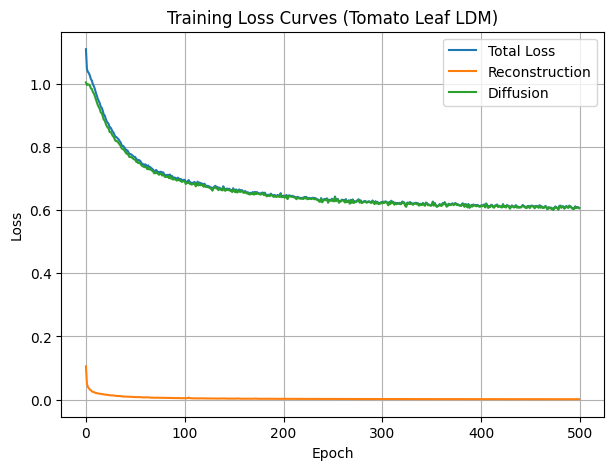

✅ Training complete. Plots & checkpoints saved.


In [ ]:
#LEAFMINER
# ============================================================
# 🍅 TOMATO LEAF LDM TRAINING (256x256)
# 🔥 Latent Diffusion + KL + DDPM Noise
# ============================================================

import os, math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# ✅ CONFIG
# -------------------------------
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
EPOCHS = 500
LR = 2e-4
TIMESTEPS = 1000

DATA_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Leaf Miner"
OUT_DIR   = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LM"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# ✅ DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------
# ✅ DATASET
# -------------------------------
class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith((".jpg", ".png"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

dataset = SingleClassImageDataset(DATA_PATH, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# -------------------------------
# 🧠 MODELS (FIXED FOR 256x256)
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),      # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),# 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),# 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),  # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, d)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 512 * 8 * 8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )
    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))

class LatentUNet(nn.Module):
    def __init__(self, d, t):
        super().__init__()
        self.time_embed = nn.Embedding(t, d)
        self.net = nn.Sequential(
            nn.Linear(d, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, d)
        )
    def forward(self, x, t):
        return self.net(x + self.time_embed(t))

encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet    = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(unet.parameters()), lr=LR
)

# -------------------------------
# 📊 DIFFUSION SCHEDULE
# -------------------------------
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# -------------------------------
# 📈 LOGS
# -------------------------------
total_losses, recon_losses, diff_losses = [], [], []

# -------------------------------
# 🚀 TRAINING
# -------------------------------
print("🚀 Training started...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); unet.train()
    epoch_tot, epoch_rec, epoch_diff = 0, 0, 0

    for imgs,_ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)

        with autocast(device_type=device.type):
            z = encoder(imgs)
            recon = decoder(z)
            rec_loss = F.mse_loss(recon, imgs)

            t = torch.randint(0, TIMESTEPS, (z.size(0),), device=device)
            noise = torch.randn_like(z)
            a = alpha_hat[t][:, None]
            z_noisy = a.sqrt()*z + (1-a).sqrt()*noise

            pred = unet(z_noisy, t)
            diff_loss = F.mse_loss(pred, noise)

            loss = rec_loss + diff_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_tot += loss.item()
        epoch_rec += rec_loss.item()
        epoch_diff += diff_loss.item()

    total_losses.append(epoch_tot/len(loader))
    recon_losses.append(epoch_rec/len(loader))
    diff_losses.append(epoch_diff/len(loader))

    # 🔍 Save samples + checkpoints
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            x,_ = next(iter(loader))
            s = decoder(encoder(x.to(device)))
            save_image((s+1)/2, f"{OUT_DIR}/sample_epoch_{epoch+1}.png", nrow=4)

        torch.save(encoder.state_dict(), f"{OUT_DIR}/encoder_{epoch+1}.pth")
        torch.save(decoder.state_dict(), f"{OUT_DIR}/decoder_{epoch+1}.pth")
        torch.save(unet.state_dict(),    f"{OUT_DIR}/unet_{epoch+1}.pth")

# -------------------------------
# 📊 PLOTS (Q1-READY)
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction")
plt.plot(diff_losses, label="Diffusion")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Curves (Tomato Leaf LDM)")
plt.savefig(f"{OUT_DIR}/training_losses.png", dpi=300)
plt.show()

print("✅ Training complete. Plots & checkpoints saved.")


In [ ]:
# ============================================================
# 🍅 LDM GENERATION (256x256) — ONE CELL FIXED VERSION
# ✔ Fixes size-mismatch error
# ✔ Matches trained 256x256 checkpoints
# ✔ Generates 5000 images
# ✔ Saves + ZIPs output
# ============================================================

import torch, os, zipfile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as T
from itertools import cycle
from tqdm import tqdm

# ===================== CONFIG =====================
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
NUM_SAMPLES = 5000

DATA_PATH  = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Leaf Miner"
MODEL_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LM"
OUTPUT_DIR = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LM_generated"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET =====================
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loader = DataLoader(
    SingleClassImageDataset(DATA_PATH, transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# ===================== MODELS (256x256 CORRECT) =====================
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),              # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),           # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, latent_dim)                # ✅ FIX
        )

    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 8 * 8)          # ✅ FIX
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )

    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))       # ✅ FIX

# ===================== LOAD CHECKPOINTS =====================
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)

encoder.load_state_dict(torch.load(f"{MODEL_PATH}/encoder_500.pth", map_location=device))
decoder.load_state_dict(torch.load(f"{MODEL_PATH}/decoder_500.pth", map_location=device))

encoder.eval()
decoder.eval()

print("✅ Encoder & Decoder loaded correctly (256×256)")

# ===================== GENERATION =====================
@torch.no_grad()
def generate_images(encoder, decoder, dataloader, num_samples):
    count = 0
    loop_loader = cycle(dataloader)

    for images, _ in tqdm(loop_loader, desc="Generating Images"):
        images = images.to(device)
        z = encoder(images)
        imgs = decoder(z)
        imgs = (imgs + 1) / 2  # [-1,1] → [0,1]

        for img in imgs:
            save_image(img, f"{OUTPUT_DIR}/tomato_ldm_{count:05}.png")
            count += 1
            if count >= num_samples:
                return

generate_images(encoder, decoder, loader, NUM_SAMPLES)

# ===================== ZIP OUTPUT =====================
zip_path = OUTPUT_DIR + ".zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, f), arcname=f)

print(f"✅ Generated {NUM_SAMPLES} tomato leaf images")
print(f"📦 ZIP saved at: {zip_path}")


✅ Encoder & Decoder loaded correctly (256×256)


Generating Images: 624it [03:27,  3.00it/s]


✅ Generated 5000 tomato leaf images
📦 ZIP saved at: /content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/LM_generated.zip


🚀 Training started...


Epoch 500/500: 100%|██████████| 117/117 [00:02<00:00, 47.53it/s]


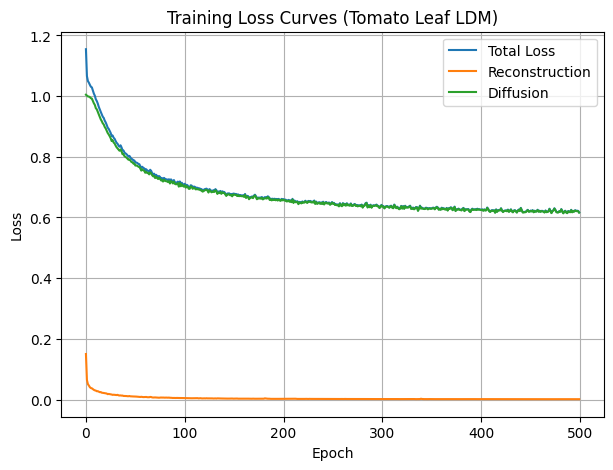

✅ Training complete. Plots & checkpoints saved.


In [ ]:
#MAGNESIUM DEFICIENCY
# ============================================================
# 🍅 TOMATO LEAF LDM TRAINING (256x256)
# 🔥 Latent Diffusion + KL + DDPM Noise
# ============================================================

import os, math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# ✅ CONFIG
# -------------------------------
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
EPOCHS = 500
LR = 2e-4
TIMESTEPS = 1000

DATA_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Magnesium Deficiency"
OUT_DIR   = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/MD"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# ✅ DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------
# ✅ DATASET
# -------------------------------
class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith((".jpg", ".png"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

dataset = SingleClassImageDataset(DATA_PATH, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# -------------------------------
# 🧠 MODELS (FIXED FOR 256x256)
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),      # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),# 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),# 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),  # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, d)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 512 * 8 * 8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )
    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))

class LatentUNet(nn.Module):
    def __init__(self, d, t):
        super().__init__()
        self.time_embed = nn.Embedding(t, d)
        self.net = nn.Sequential(
            nn.Linear(d, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, d)
        )
    def forward(self, x, t):
        return self.net(x + self.time_embed(t))

encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet    = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(unet.parameters()), lr=LR
)

# -------------------------------
# 📊 DIFFUSION SCHEDULE
# -------------------------------
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# -------------------------------
# 📈 LOGS
# -------------------------------
total_losses, recon_losses, diff_losses = [], [], []

# -------------------------------
# 🚀 TRAINING
# -------------------------------
print("🚀 Training started...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); unet.train()
    epoch_tot, epoch_rec, epoch_diff = 0, 0, 0

    for imgs,_ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)

        with autocast(device_type=device.type):
            z = encoder(imgs)
            recon = decoder(z)
            rec_loss = F.mse_loss(recon, imgs)

            t = torch.randint(0, TIMESTEPS, (z.size(0),), device=device)
            noise = torch.randn_like(z)
            a = alpha_hat[t][:, None]
            z_noisy = a.sqrt()*z + (1-a).sqrt()*noise

            pred = unet(z_noisy, t)
            diff_loss = F.mse_loss(pred, noise)

            loss = rec_loss + diff_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_tot += loss.item()
        epoch_rec += rec_loss.item()
        epoch_diff += diff_loss.item()

    total_losses.append(epoch_tot/len(loader))
    recon_losses.append(epoch_rec/len(loader))
    diff_losses.append(epoch_diff/len(loader))

    # 🔍 Save samples + checkpoints
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            x,_ = next(iter(loader))
            s = decoder(encoder(x.to(device)))
            save_image((s+1)/2, f"{OUT_DIR}/sample_epoch_{epoch+1}.png", nrow=4)

        torch.save(encoder.state_dict(), f"{OUT_DIR}/encoder_{epoch+1}.pth")
        torch.save(decoder.state_dict(), f"{OUT_DIR}/decoder_{epoch+1}.pth")
        torch.save(unet.state_dict(),    f"{OUT_DIR}/unet_{epoch+1}.pth")

# -------------------------------
# 📊 PLOTS (Q1-READY)
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction")
plt.plot(diff_losses, label="Diffusion")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Curves (Tomato Leaf LDM)")
plt.savefig(f"{OUT_DIR}/training_losses.png", dpi=300)
plt.show()

print("✅ Training complete. Plots & checkpoints saved.")


In [ ]:
# ============================================================
# 🍅 LDM GENERATION (256x256) — ONE CELL FIXED VERSION
# ✔ Fixes size-mismatch error
# ✔ Matches trained 256x256 checkpoints
# ✔ Generates 5000 images
# ✔ Saves + ZIPs output
# ============================================================

import torch, os, zipfile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as T
from itertools import cycle
from tqdm import tqdm

# ===================== CONFIG =====================
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
NUM_SAMPLES = 5000

DATA_PATH  = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Magnesium Deficiency"
MODEL_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/MD"
OUTPUT_DIR = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/MD_generated"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET =====================
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loader = DataLoader(
    SingleClassImageDataset(DATA_PATH, transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# ===================== MODELS (256x256 CORRECT) =====================
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),              # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),           # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, latent_dim)                # ✅ FIX
        )

    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 8 * 8)          # ✅ FIX
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )

    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))       # ✅ FIX

# ===================== LOAD CHECKPOINTS =====================
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)

encoder.load_state_dict(torch.load(f"{MODEL_PATH}/encoder_500.pth", map_location=device))
decoder.load_state_dict(torch.load(f"{MODEL_PATH}/decoder_500.pth", map_location=device))

encoder.eval()
decoder.eval()

print("✅ Encoder & Decoder loaded correctly (256×256)")

# ===================== GENERATION =====================
@torch.no_grad()
def generate_images(encoder, decoder, dataloader, num_samples):
    count = 0
    loop_loader = cycle(dataloader)

    for images, _ in tqdm(loop_loader, desc="Generating Images"):
        images = images.to(device)
        z = encoder(images)
        imgs = decoder(z)
        imgs = (imgs + 1) / 2  # [-1,1] → [0,1]

        for img in imgs:
            save_image(img, f"{OUTPUT_DIR}/tomato_ldm_{count:05}.png")
            count += 1
            if count >= num_samples:
                return

generate_images(encoder, decoder, loader, NUM_SAMPLES)

# ===================== ZIP OUTPUT =====================
zip_path = OUTPUT_DIR + ".zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, f), arcname=f)

print(f"✅ Generated {NUM_SAMPLES} tomato leaf images")
print(f"📦 ZIP saved at: {zip_path}")


✅ Encoder & Decoder loaded correctly (256×256)


Generating Images: 624it [03:00,  3.46it/s]


✅ Generated 5000 tomato leaf images
📦 ZIP saved at: /content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/MD_generated.zip


🚀 Training started...


Epoch 500/500: 100%|██████████| 27/27 [00:00<00:00, 34.86it/s]


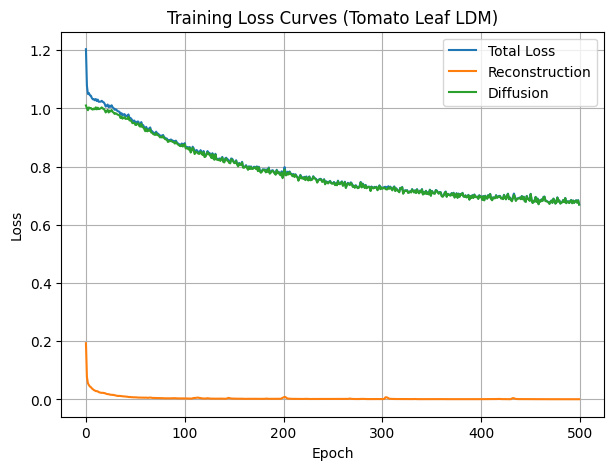

✅ Training complete. Plots & checkpoints saved.


In [ ]:
#MAGNESIUM DEFICIENCY
# ============================================================
# 🍅 TOMATO LEAF LDM TRAINING (256x256)
# 🔥 Latent Diffusion + KL + DDPM Noise
# ============================================================

import os, math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# ✅ CONFIG
# -------------------------------
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
EPOCHS = 500
LR = 2e-4
TIMESTEPS = 1000

DATA_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Healthy"
OUT_DIR   = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/THEALTHY"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# ✅ DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------
# ✅ DATASET
# -------------------------------
class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith((".jpg", ".png"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

dataset = SingleClassImageDataset(DATA_PATH, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# -------------------------------
# 🧠 MODELS (FIXED FOR 256x256)
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),      # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),# 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),# 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),  # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, d)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 512 * 8 * 8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )
    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))

class LatentUNet(nn.Module):
    def __init__(self, d, t):
        super().__init__()
        self.time_embed = nn.Embedding(t, d)
        self.net = nn.Sequential(
            nn.Linear(d, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, d)
        )
    def forward(self, x, t):
        return self.net(x + self.time_embed(t))

encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet    = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(unet.parameters()), lr=LR
)

# -------------------------------
# 📊 DIFFUSION SCHEDULE
# -------------------------------
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# -------------------------------
# 📈 LOGS
# -------------------------------
total_losses, recon_losses, diff_losses = [], [], []

# -------------------------------
# 🚀 TRAINING
# -------------------------------
print("🚀 Training started...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); unet.train()
    epoch_tot, epoch_rec, epoch_diff = 0, 0, 0

    for imgs,_ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)

        with autocast(device_type=device.type):
            z = encoder(imgs)
            recon = decoder(z)
            rec_loss = F.mse_loss(recon, imgs)

            t = torch.randint(0, TIMESTEPS, (z.size(0),), device=device)
            noise = torch.randn_like(z)
            a = alpha_hat[t][:, None]
            z_noisy = a.sqrt()*z + (1-a).sqrt()*noise

            pred = unet(z_noisy, t)
            diff_loss = F.mse_loss(pred, noise)

            loss = rec_loss + diff_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_tot += loss.item()
        epoch_rec += rec_loss.item()
        epoch_diff += diff_loss.item()

    total_losses.append(epoch_tot/len(loader))
    recon_losses.append(epoch_rec/len(loader))
    diff_losses.append(epoch_diff/len(loader))

    # 🔍 Save samples + checkpoints
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            x,_ = next(iter(loader))
            s = decoder(encoder(x.to(device)))
            save_image((s+1)/2, f"{OUT_DIR}/sample_epoch_{epoch+1}.png", nrow=4)

        torch.save(encoder.state_dict(), f"{OUT_DIR}/encoder_{epoch+1}.pth")
        torch.save(decoder.state_dict(), f"{OUT_DIR}/decoder_{epoch+1}.pth")
        torch.save(unet.state_dict(),    f"{OUT_DIR}/unet_{epoch+1}.pth")

# -------------------------------
# 📊 PLOTS (Q1-READY)
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction")
plt.plot(diff_losses, label="Diffusion")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Curves (Tomato Leaf LDM)")
plt.savefig(f"{OUT_DIR}/training_losses.png", dpi=300)
plt.show()

print("✅ Training complete. Plots & checkpoints saved.")


In [ ]:
# ============================================================
# 🍅 LDM GENERATION (256x256) — ONE CELL FIXED VERSION
# ✔ Fixes size-mismatch error
# ✔ Matches trained 256x256 checkpoints
# ✔ Generates 5000 images
# ✔ Saves + ZIPs output
# ============================================================

import torch, os, zipfile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as T
from itertools import cycle
from tqdm import tqdm

# ===================== CONFIG =====================
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
NUM_SAMPLES = 5000

DATA_PATH  = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Healthy"
MODEL_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/THEALTHY"
OUTPUT_DIR = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/HEALTHY_generated"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET =====================
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loader = DataLoader(
    SingleClassImageDataset(DATA_PATH, transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# ===================== MODELS (256x256 CORRECT) =====================
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),              # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),           # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, latent_dim)                # ✅ FIX
        )

    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 8 * 8)          # ✅ FIX
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )

    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))       # ✅ FIX

# ===================== LOAD CHECKPOINTS =====================
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)

encoder.load_state_dict(torch.load(f"{MODEL_PATH}/encoder_500.pth", map_location=device))
decoder.load_state_dict(torch.load(f"{MODEL_PATH}/decoder_500.pth", map_location=device))

encoder.eval()
decoder.eval()

print("✅ Encoder & Decoder loaded correctly (256×256)")

# ===================== GENERATION =====================
@torch.no_grad()
def generate_images(encoder, decoder, dataloader, num_samples):
    count = 0
    loop_loader = cycle(dataloader)

    for images, _ in tqdm(loop_loader, desc="Generating Images"):
        images = images.to(device)
        z = encoder(images)
        imgs = decoder(z)
        imgs = (imgs + 1) / 2  # [-1,1] → [0,1]

        for img in imgs:
            save_image(img, f"{OUTPUT_DIR}/tomato_ldm_{count:05}.png")
            count += 1
            if count >= num_samples:
                return

generate_images(encoder, decoder, loader, NUM_SAMPLES)

# ===================== ZIP OUTPUT =====================
zip_path = OUTPUT_DIR + ".zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, f), arcname=f)

print(f"✅ Generated {NUM_SAMPLES} tomato leaf images")
print(f"📦 ZIP saved at: {zip_path}")


✅ Encoder & Decoder loaded correctly (256×256)


Generating Images: 624it [03:12,  3.24it/s]


✅ Generated 5000 tomato leaf images
📦 ZIP saved at: /content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/HEALTHY_generated.zip


🚀 Training started...


Epoch 500/500: 100%|██████████| 65/65 [00:02<00:00, 24.27it/s]


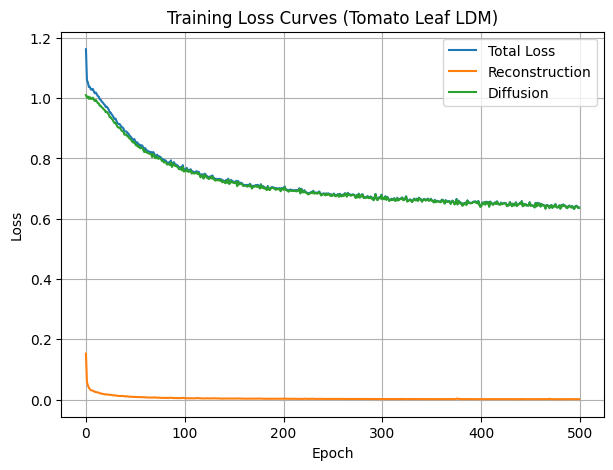

✅ Training complete. Plots & checkpoints saved.


In [2]:
#Spotted Wilt Virus
# ============================================================
# 🍅 TOMATO LEAF LDM TRAINING (256x256)
# 🔥 Latent Diffusion + KL + DDPM Noise
# ============================================================

import os, math
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

# -------------------------------
# ✅ CONFIG
# -------------------------------
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
EPOCHS = 500
LR = 2e-4
TIMESTEPS = 1000

DATA_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Spotted Wilt Virus"
OUT_DIR   = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/SWV"

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# ✅ DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -------------------------------
# ✅ DATASET
# -------------------------------
class SingleClassImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.lower().endswith((".jpg", ".png"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

dataset = SingleClassImageDataset(DATA_PATH, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# -------------------------------
# 🧠 MODELS (FIXED FOR 256x256)
# -------------------------------
class Encoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),      # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),# 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(),# 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),  # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, d)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 512 * 8 * 8)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )
    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))

class LatentUNet(nn.Module):
    def __init__(self, d, t):
        super().__init__()
        self.time_embed = nn.Embedding(t, d)
        self.net = nn.Sequential(
            nn.Linear(d, 1024), nn.ReLU(),
            nn.Linear(1024, 1024), nn.ReLU(),
            nn.Linear(1024, d)
        )
    def forward(self, x, t):
        return self.net(x + self.time_embed(t))

encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)
unet    = LatentUNet(LATENT_DIM, TIMESTEPS).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(unet.parameters()), lr=LR
)

# -------------------------------
# 📊 DIFFUSION SCHEDULE
# -------------------------------
betas = torch.linspace(1e-4, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# -------------------------------
# 📈 LOGS
# -------------------------------
total_losses, recon_losses, diff_losses = [], [], []

# -------------------------------
# 🚀 TRAINING
# -------------------------------
print("🚀 Training started...")
for epoch in range(EPOCHS):
    encoder.train(); decoder.train(); unet.train()
    epoch_tot, epoch_rec, epoch_diff = 0, 0, 0

    for imgs,_ in tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)

        with autocast(device_type=device.type):
            z = encoder(imgs)
            recon = decoder(z)
            rec_loss = F.mse_loss(recon, imgs)

            t = torch.randint(0, TIMESTEPS, (z.size(0),), device=device)
            noise = torch.randn_like(z)
            a = alpha_hat[t][:, None]
            z_noisy = a.sqrt()*z + (1-a).sqrt()*noise

            pred = unet(z_noisy, t)
            diff_loss = F.mse_loss(pred, noise)

            loss = rec_loss + diff_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_tot += loss.item()
        epoch_rec += rec_loss.item()
        epoch_diff += diff_loss.item()

    total_losses.append(epoch_tot/len(loader))
    recon_losses.append(epoch_rec/len(loader))
    diff_losses.append(epoch_diff/len(loader))

    # 🔍 Save samples + checkpoints
    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            x,_ = next(iter(loader))
            s = decoder(encoder(x.to(device)))
            save_image((s+1)/2, f"{OUT_DIR}/sample_epoch_{epoch+1}.png", nrow=4)

        torch.save(encoder.state_dict(), f"{OUT_DIR}/encoder_{epoch+1}.pth")
        torch.save(decoder.state_dict(), f"{OUT_DIR}/decoder_{epoch+1}.pth")
        torch.save(unet.state_dict(),    f"{OUT_DIR}/unet_{epoch+1}.pth")

# -------------------------------
# 📊 PLOTS (Q1-READY)
# -------------------------------
plt.figure(figsize=(7,5))
plt.plot(total_losses, label="Total Loss")
plt.plot(recon_losses, label="Reconstruction")
plt.plot(diff_losses, label="Diffusion")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Curves (Tomato Leaf LDM)")
plt.savefig(f"{OUT_DIR}/training_losses.png", dpi=300)
plt.show()

print("✅ Training complete. Plots & checkpoints saved.")


In [3]:
# ============================================================
# 🍅 LDM GENERATION (256x256) — ONE CELL FIXED VERSION
# ✔ Fixes size-mismatch error
# ✔ Matches trained 256x256 checkpoints
# ✔ Generates 5000 images
# ✔ Saves + ZIPs output
# ============================================================

import torch, os, zipfile
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms as T
from itertools import cycle
from tqdm import tqdm

# ===================== CONFIG =====================
IMG_SIZE = 256
LATENT_DIM = 1024
BATCH_SIZE = 8
NUM_SAMPLES = 5000

DATA_PATH  = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/Spotted Wilt Virus"
MODEL_PATH = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/SWV"
OUTPUT_DIR = "/content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/SWV_generated"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== DATASET =====================
class SingleClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, f)
                      for f in os.listdir(root_dir)
                      if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, 0

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

loader = DataLoader(
    SingleClassImageDataset(DATA_PATH, transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# ===================== MODELS (256x256 CORRECT) =====================
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),              # 128
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 64
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU(),           # 8
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, latent_dim)                # ✅ FIX
        )

    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 8 * 8)          # ✅ FIX
        self.net = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), # 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()                           # 256
        )

    def forward(self, z):
        return self.net(self.fc(z).view(-1, 512, 8, 8))       # ✅ FIX

# ===================== LOAD CHECKPOINTS =====================
encoder = Encoder(LATENT_DIM).to(device)
decoder = Decoder(LATENT_DIM).to(device)

encoder.load_state_dict(torch.load(f"{MODEL_PATH}/encoder_500.pth", map_location=device))
decoder.load_state_dict(torch.load(f"{MODEL_PATH}/decoder_500.pth", map_location=device))

encoder.eval()
decoder.eval()

print("✅ Encoder & Decoder loaded correctly (256×256)")

# ===================== GENERATION =====================
@torch.no_grad()
def generate_images(encoder, decoder, dataloader, num_samples):
    count = 0
    loop_loader = cycle(dataloader)

    for images, _ in tqdm(loop_loader, desc="Generating Images"):
        images = images.to(device)
        z = encoder(images)
        imgs = decoder(z)
        imgs = (imgs + 1) / 2  # [-1,1] → [0,1]

        for img in imgs:
            save_image(img, f"{OUTPUT_DIR}/tomato_ldm_{count:05}.png")
            count += 1
            if count >= num_samples:
                return

generate_images(encoder, decoder, loader, NUM_SAMPLES)

# ===================== ZIP OUTPUT =====================
zip_path = OUTPUT_DIR + ".zip"
with zipfile.ZipFile(zip_path, "w") as zipf:
    for f in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, f), arcname=f)

print(f"✅ Generated {NUM_SAMPLES} tomato leaf images")
print(f"📦 ZIP saved at: {zip_path}")


✅ Encoder & Decoder loaded correctly (256×256)


Generating Images: 628it [03:04,  3.41it/s]


✅ Generated 5000 tomato leaf images
📦 ZIP saved at: /content/drive/MyDrive/TOMATO_LEAF_DATASET/LDM_OUTPUTS/SWV_generated.zip
